In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [24]:
print("Loading data...")

df = pd.read_csv('../data/dataset.csv')

# Convert rows to transaction lists (removing NaNs and underscores)
transactions = []
for i in range(len(df)):
    # Grab all columns starting from index 1 (skip Disease column)
    row_values = df.iloc[i, 1:].values.flatten().tolist()
    
    # Clean: Ensure it's a string, not empty, and remove underscores
    clean_row = [
        str(x).strip().replace('_', ' ') 
        for x in row_values 
        if pd.notna(x) and str(x).strip() != '' and str(x).lower() != 'nan'
    ]
    transactions.append(clean_row)

print(f"Processed {len(transactions)} transactions.")

Loading data...
Processed 4920 transactions.


In [25]:
te = TransactionEncoder()
# Use sparse=True to prevent MemoryError
te_ary = te.fit(transactions).transform(transactions, sparse=True)

# --- THE FIX: Calculate counts using the raw matrix to ensure REAL numbers ---
# axis=0 counts how often an item appears (Frequency)
# axis=1 counts how many items a patient has (Basket Size)
item_counts = np.array(te_ary.sum(axis=0)).flatten()
basket_sizes = np.array(te_ary.sum(axis=1)).flatten()

# Create the dataframe for Apriori
df_encoded = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)
print(f"Matrix shape: {df_encoded.shape}")

Matrix shape: (4920, 131)


C:\Users\angel\AppData\Local\Temp\ipykernel_13124\811832585.py:12: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_encoded = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)


Saved basket size plot.


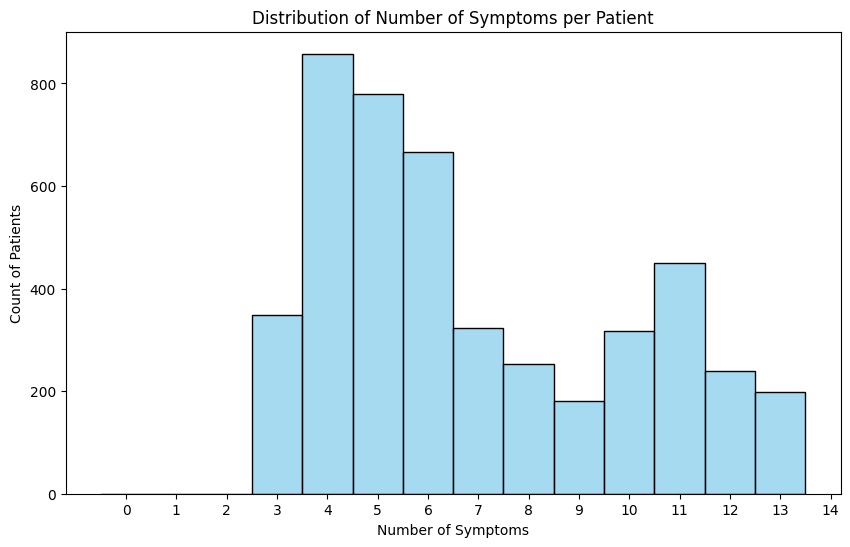

Saved frequency plot.


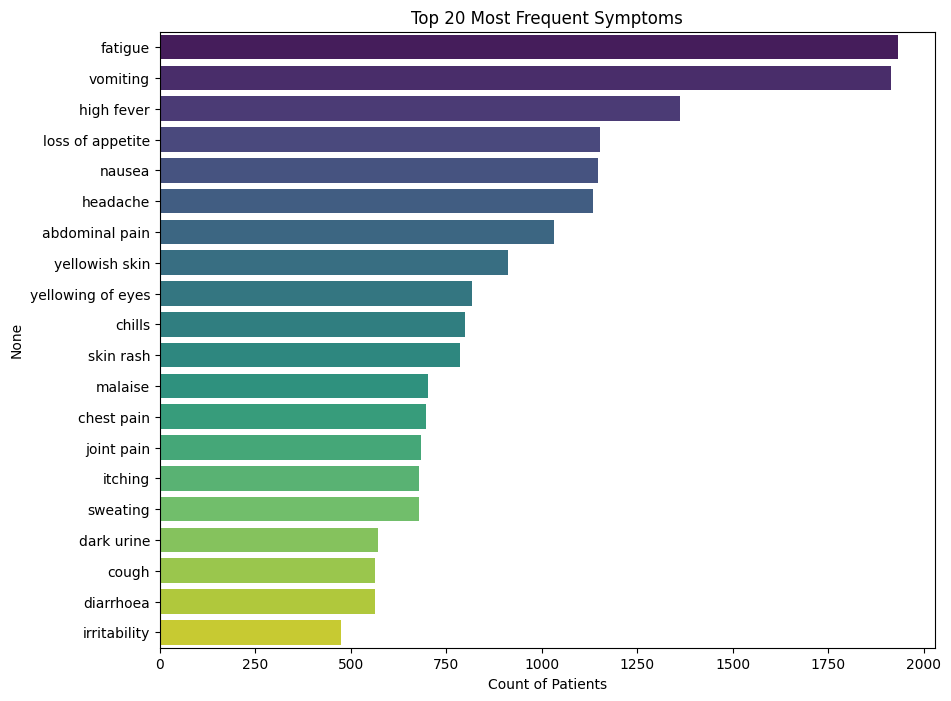

Saved 'Smart' heatmap to results/heatmap.png


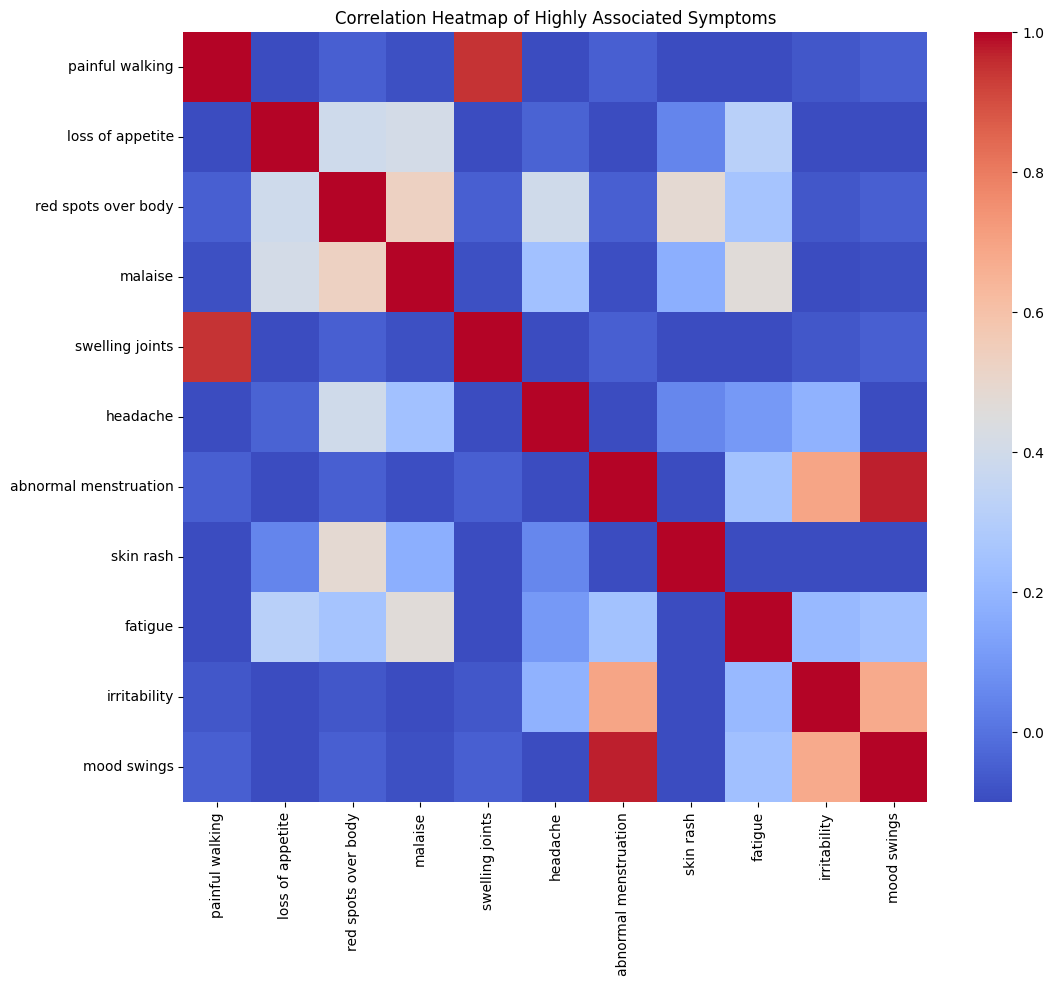

In [ ]:
# --- A. Basket Size Analysis ---
plt.figure(figsize=(10, 6))
# We use the 'basket_sizes' variable we calculated above (NOT df.sum)
sns.histplot(basket_sizes, bins=np.arange(0, 15) - 0.5, kde=False, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Symptoms per Patient')
plt.xlabel('Number of Symptoms')
plt.ylabel('Count of Patients')
plt.xticks(range(0, 15))
plt.savefig('../results/basket_size_dist.png')
print("Saved basket size plot.")
plt.show()

In [ ]:
# --- B. Frequency Plot ---
# We use 'item_counts' to ensure we get real numbers like 500, 1000, etc.
freq_series = pd.Series(item_counts, index=te.columns_)
top_20 = freq_series.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_20.values, y=top_20.index, hue=top_20.index, palette='viridis', legend=False)
plt.title('Top 20 Most Frequent Symptoms')
plt.xlabel('Count of Patients')
plt.savefig('../results/symptom_frequency.png')
print("Saved frequency plot.")
plt.show()

In [27]:
print("Running Apriori...")
frequent_itemsets = apriori(df_encoded, min_support=0.03, use_colnames=True, max_len=3, low_memory=True)

print(f"Found {len(frequent_itemsets)} frequent itemsets.")

if len(frequent_itemsets) > 0:
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
    rules = rules.sort_values(by='lift', ascending=False)
    
    # Select ALL required metrics
    final_cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift', 'leverage', 'conviction']
    final_results = rules[final_cols]
    
    final_results.to_csv('../results/rules.csv', index=False)
    print("Success! Rules saved to results/rules.csv")
    print(final_results.head())
else:
    print("No itemsets found. Try lowering min_support.")

Running Apriori...
Found 624 frequent itemsets.
Success! Rules saved to results/rules.csv
                               antecedents  \
24                 (abnormal menstruation)   
614            (irritability, mood swings)   
612  (abnormal menstruation, irritability)   
617                          (mood swings)   
615                (abnormal menstruation)   

                               consequents   support  confidence  lift  \
24                           (mood swings)  0.046341        0.95  20.5   
614                (abnormal menstruation)  0.046341        1.00  20.5   
612                          (mood swings)  0.046341        0.95  20.5   
617  (abnormal menstruation, irritability)  0.046341        1.00  20.5   
615            (irritability, mood swings)  0.046341        0.95  20.5   

     leverage  conviction  
24   0.044081   19.073171  
614  0.044081         inf  
612  0.044081   19.073171  
617  0.044081         inf  
615  0.044081   19.073171  


In [ ]:
# --- C. Smart Co-occurrence Heatmap ---
# We run this LAST because it needs the 'rules' variable from Step 4
print("Generating Smart Heatmap...")

# Get items involved in the top 20 strong rules
top_rules_items = set()
if not rules.empty:
    for i, row in rules.head(20).iterrows():
        top_rules_items.update(list(row['antecedents']))
        top_rules_items.update(list(row['consequents']))

    # Convert to list and limit to 30 items
    heatmap_items = list(top_rules_items)[:30]

    if len(heatmap_items) > 1:
        # Filter original data to just these "Strong" items
        # Use dense matrix for correlation calculation
        subset_df = df_encoded[heatmap_items].sparse.to_dense() 
        corr_matrix = subset_df.corr()

        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-0.1, vmax=1.0)
        plt.title('Correlation Heatmap of Highly Associated Symptoms')
        plt.savefig('../results/heatmap.png')
        print("Saved 'Smart' heatmap to results/heatmap.png")
        plt.show()
    else:
        print("Not enough items in rules to plot a heatmap.")
else:
    print("No rules found, skipping heatmap.")